In [47]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import control 
import sys
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import plot
import time
import igraph as ig
from scipy.optimize import brentq
from scipy.optimize import minimize, LinearConstraint



Neural Lyapunov Function Verification via Hyperplane Arrangements -  Functions

In [55]:

def get_polygon_centroid(vertex_coords):
    x_coords = [coord[0] for coord in vertex_coords]
    y_coords = [coord[1] for coord in vertex_coords]
    centroid_x = sum(x_coords) / len(vertex_coords)
    centroid_y = sum(y_coords) / len(vertex_coords)
    return (centroid_x, centroid_y)

#when we treat the edges of the rectangle as planes, the edge is only finite so have to get rid off stuff outside the rect
def is_within_rect(point, x1_min, x1_max, x2_min, x2_max, tol=1e-8):
    return (x1_min - tol <= point[0] <= x1_max + tol) and (x2_min - tol <= point[1] <= x2_max + tol)

def find_intersection(plane_1_normal, plane_1_bias, plane_2_normal, plane_2_bias):
    A = np.array([plane_1_normal, plane_2_normal])
    #if the det is close to zero, the planes are parallel and they do not intersect 
    det = np.linalg.det(A) 
    tol = 1e-6
    if abs(det) < tol:
        return None  
    b = np.array([-plane_1_bias, -plane_2_bias])
    intersection_point = np.linalg.solve(A, b)
    return intersection_point

#given two points, see if they are on the same plane 
def neighbor_finder(pt1, pt2, W_matrix, B_vector, tol=1e-6):
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i= B_vector[i]
        #pt 1
        if (abs(pt1 @ w_i + b_i) < tol) and (abs(pt2 @ w_i + b_i) < tol):
            #then we found a neighbor
            return True
    return False

def find_all_intersection_points(W_matrix, B_vector, f_functions, x1_min, x1_max, x2_min, x2_max):
    #we have a list of planes, and we need to find all the intersection points 
    #x1_search_interval =  np.linspace(-50, 50, 100)
    x1_search_interval =  np.linspace(x1_min, x1_max, x1_max - x1_min)
    intersection_points = []
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        for j in range(i+1, W_matrix.shape[1]):
            w_j = W_matrix[:, j]
            b_j = B_vector[j]
            intersection_point = find_intersection(w_i, b_i, w_j, b_j)
            #check if the intersection point is within the range of our training data
            if(intersection_point is not None):
                intersection_points.append(intersection_point)
####################################################################################################################
    #Okay now that we have the intersecition points of the planes with each other, we need to know
    # #where the planes intersect with the dynamics f1 and f2
    dynamic_intersections = []
    obj = lambda x1:  f_functions[1](x1) - f_functions[0](x1)
    x2_out = obj(x1_search_interval)
    sign_changes = np.where(np.diff(np.sign(x2_out)) != 0)[0]
    for idx in sign_changes:
        lower_bound = x1_search_interval[idx]
        upper_bound = x1_search_interval[idx+1]
                
        # Guard against exact zeros found during the scan
        if obj(lower_bound) == 0:
            dynamic_intersections.append((lower_bound, f_functions[1](root)))
        else:
            root = brentq(obj, lower_bound, upper_bound)
            dynamic_intersections.append((root, f_functions[1](root)))            
######################################################################################################################    
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        #check intersection with each edge of the rectangle, using my old function and treating each edge as a plane 
        #edge 1: x2 = x2_min
        plane_normal = w_i
        plane_bias = b_i
        edge_normal = np.array([0, 1])
        edge_bias = -x2_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
         #edge 2: x2 = x2_max
        edge_bias = -x2_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 3: x1 = x1_min
        edge_normal = np.array([1, 0])
        edge_bias = -x1_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 4: x1 = x1_max
        edge_bias = -x1_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        
    #now add the rectangle corners as well
    corners = [(x1_min, x2_min), (x1_min, x2_max), (x1_max, x2_min), (x1_max, x2_max)]  
    for corner in corners:
        intersection_points.append(corner)
    #get rid of intersections that occur outside of the rectangle
    
    valid_intersection_points = []
    for point in intersection_points:
        if is_within_rect(point, x1_min, x1_max, x2_min, x2_max):
            valid_intersection_points.append(point)
    
    #also get rid of dynamic intersections that occur outside of the rectangle (Region of Interest)
    valid_dynamic_intersections = []
    for point in dynamic_intersections:
        if is_within_rect(point, x1_min, x1_max, x2_min, x2_max):
            valid_dynamic_intersections.append(point)

    return valid_intersection_points, valid_dynamic_intersections

# helper function to connect nodes on each edge of the square
def connect_consecutive_on_edge(points_on_edge, edge_name, edge_list):
    if len(points_on_edge) < 2: #only one point on an edge, so dont do anything 
        return edge_list
        
    # sort points from left to right or  down to up (depending on which edge)
    if edge_name in ['left', 'right']:
        # sort by x2 coordinate
        points_on_edge.sort(key=lambda p: p[1][1])
    else:  # top or bottom
        # sort by x1 coordinate
        points_on_edge.sort(key=lambda p: p[1][0])
        
    # now that they are in consecutive order, connect them in that order
    for k in range(len(points_on_edge) - 1):
        v_str_1 = points_on_edge[k][0]
        v_str_2 = points_on_edge[k+1][0]
        edge_list.append((v_str_1, v_str_2))
    return edge_list

def get_planar_graph(intersection_points, W_matrix, B_vector, x1_min, x1_max, x2_min, x2_max, tol=1e-6):

    # first create vertex dictionary
    vertex_set = {}
    for i in range(len(intersection_points)):
        v_str = f'v{i}'
        vertex_set[v_str] = intersection_points[i]
    
    # Edge list
    edge_list = []
    
    #put connect the vertices on the edges of the region of interest squre 
    # collect points on each edge
    left_edge_points = []
    right_edge_points = []
    bottom_edge_points = []
    top_edge_points = []
    
    for i in range(len(intersection_points)):
        this_vertex = intersection_points[i]
        x1_coord = this_vertex[0]
        x2_coord = this_vertex[1]
        v_str = f'v{i}'
        
        if abs(x1_coord - x1_min) < tol:
            left_edge_points.append((v_str, this_vertex))
        if abs(x1_coord - x1_max) < tol:
            right_edge_points.append((v_str, this_vertex))
        if abs(x2_coord - x2_min) < tol:
            bottom_edge_points.append((v_str, this_vertex))
        if abs(x2_coord - x2_max) < tol:
            top_edge_points.append((v_str, this_vertex))
    
    # connect consecutive points on each edge
    edge_list = connect_consecutive_on_edge(left_edge_points, 'left', edge_list)
    edge_list = connect_consecutive_on_edge(right_edge_points, 'right', edge_list)
    edge_list = connect_consecutive_on_edge(bottom_edge_points, 'bottom', edge_list)
    edge_list = connect_consecutive_on_edge(top_edge_points, 'top', edge_list)
    
    # now add the vertices that are inside the square, order them if they are on the same plane, and then connect them 
    for plane_idx in range(W_matrix.shape[1]):
        w_i = W_matrix[:, plane_idx]
        b_i = B_vector[plane_idx]
        
        # find all points on this plane
        points_on_plane = []
        for i in range(len(intersection_points)):
            pt = intersection_points[i]
            if abs(pt @ w_i + b_i) < tol:
                points_on_plane.append((i, pt))
        
        # sort points along the plane
        if abs(w_i[0]) > abs(w_i[1]):  # more horizontal normal plane, sort by x2
            points_on_plane.sort(key=lambda p: p[1][1])
        else:  # more vertical normal plane, sort by x1
            points_on_plane.sort(key=lambda p: p[1][0])
        
        # connect consecutive points only
        for k in range(len(points_on_plane) - 1):
            v_str_1 = f'v{points_on_plane[k][0]}'
            v_str_2 = f'v{points_on_plane[k+1][0]}'
            edge_list.append((v_str_1, v_str_2))
    
    return vertex_set, edge_list

def step_function(x):
    if x >= 0:
        return 1
    else:
        return 0
    
def analytic_gradient(model, input_num, hidden_num, x_state):
    #first collect the edges into appropriate matrices to access
    W_matrix  = model.network[0].weight.detach().numpy().T #each column is weights into a hidden neuron [w1, w2,..., wn; w_n+1, ...]
    B_vector  = model.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
    W_out_vec = model.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]
    #W_out_vec = W_out_vec[::-1]
    W_out_matrix = np.diag(W_out_vec)  #make into diagonal matrix for for the weird element by element multiplication
    #compute activation vector at x_state: This is a stationary vector for any x_state
    U_vector = np.zeros((hidden_num, 1))
    for i in range(hidden_num):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        U_vector[i] = step_function(np.dot(w_i, x_state) + b_i)
    
    grad_vector = np.zeros((input_num, 1))
    for i in range(input_num):
        W_prime = W_out_matrix @ W_matrix[i, :].reshape(-1, 1)
        grad_vector[i] = np.dot(U_vector.T, W_prime)
    return grad_vector

def zero_level_set_crosses_edge(v1, v2, f_function):
    #rind the min and max for x2 on edge
    x1_min = min(v1[0], v2[0])
    x1_max = max(v1[0], v2[0])
    x2_min = min(v1[1], v2[1])
    x2_max = max(v1[1], v2[1])
    
    #in case the interval is big, we want to scale it based on the max distance 
    x1_diff = x1_max - x1_min
    x2_diff = x2_max - x2_min
    refine_steps = max(int(max(x1_diff, x2_diff) * 10), 100)  #at least 50 steps, more if the edge is long
    # Handle vertical edge case separatelty
    if abs(v2[0] - v1[0]) < 1e-10:
        x1_on_edge = np.full(refine_steps, v1[0]) # repeat x1 value for a vector
        x2_on_edge = np.linspace(x2_min, x2_max, refine_steps) # evenly spaced x2 values along the edge
    else:  # non-vertical edge, so jsut do a linear interpolation
        t = np.linspace(0, 1, refine_steps)
        x1_on_edge = v1[0] + t * (v2[0] - v1[0])
        x2_on_edge = v1[1] + t * (v2[1] - v1[1])
    
    # Evaluate function along the edge)
    f_on_edge = np.array([f_function(np.array([[x1], [x2]])) for x1, x2 in zip(x1_on_edge, x2_on_edge)])
    
    # If the sign changes, then the zero level set crosses the edge
    #since the positve and negative regions are crossing the edge as well (thats what we mean by sign change)
    sign_changes = np.where(np.diff(np.sign(f_on_edge)) != 0)[0]
    return True if len(sign_changes) > 0 else False

#given the vertices of a polygon, discretize a grid over it
def is_point_in_polygon(x, y, polygon_vertices):
    # count how many times a horizontal ray to the right from (x,y) intersects polygon edges.
    # If the count is odd => inside, if even => outside
    #  points exactly on an edge return False since it is a boundary
    intersections = 0
    n = len(polygon_vertices)
    for i in range(n):
        xi, yi = polygon_vertices[i]
        xj, yj = polygon_vertices[(i + 1) % n]
        # If there is a vertex above and below horizontal ray from y then maybe intersection
        if (yi > y) != (yj > y):
            # Compute x coordinate of intersection of the edge with the horizontal line y
            xinters = xi + (y - yi) * (xj - xi) / (yj - yi) #see my notes 
            # If the point lies exactly on the edge intersection, treat as outside
            if abs(xinters - x) < 1e-12:
                return False
            # Count intersection only if it is to the right of the point (just need to check one side)
            if xinters > x:
                intersections += 1
    return (intersections % 2) == 1

def discretize_polygon(polygon_vertices, resolution=50):
    x1_coords = [v[0] for v in polygon_vertices]
    x2_coords = [v[1] for v in polygon_vertices]
    x1_min_poly = min(x1_coords)
    x1_max_poly = max(x1_coords)
    x2_min_poly = min(x2_coords)
    x2_max_poly = max(x2_coords)
    #the number of points should also depend on the dimension of the polygon
    # x1_grid_poly = np.arange(x1_min_poly, x1_max_poly, grid_spacing)
    # x2_grid_poly = np.arange(x2_min_poly, x2_max_poly, grid_spacing)
    #resolution = min(resolution, int(max(x1_max_poly - x1_min_poly, x2_max_poly - x2_min_poly) * 10))
    x1_grid_poly = np.linspace(x1_min_poly, x1_max_poly, resolution)
    x2_grid_poly = np.linspace(x2_min_poly , x2_max_poly , resolution)
    #then use the grid_spaing from the function

    #get rid of first and last ones
    # x1_grid_poly = x1_grid_poly[1:-1]
    # x2_grid_poly = x2_grid_poly[1:-1]
    X1_poly, X2_poly = np.meshgrid(x1_grid_poly, x2_grid_poly)
    points_in_polygon = []
    for i in range(X1_poly.shape[0]):
        for j in range(X1_poly.shape[1]):
            x1_pt = X1_poly[i, j]
            x2_pt = X2_poly[i, j]
            if is_point_in_polygon(x1_pt, x2_pt, polygon_vertices):
                points_in_polygon.append((x1_pt, x2_pt))
    return points_in_polygon
    

def verify_point(my_nn, input_dim, hidden_layer_size, x1_val, x2_val, F_function_list):
    # Use autograd to compute gradient (matches double_verification)
    x_state = torch.tensor([[x1_val, x2_val]], dtype=torch.float32, requires_grad=True)
    V_nn = my_nn(x_state)
    V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
    
    f1 = F_function_list[0](np.array([[x1_val], [x2_val]]))
    f2 = F_function_list[1](np.array([[x1_val], [x2_val]]))
    
    dot_product = V_grad[0, 0].item() * f1 + V_grad[0, 1].item() * f2
    if(dot_product >= 0 ): # we found a counterexample
        return False
    else:
        return True # it is negative so we are good to go

def optimize_over_polygon(objective_func, polygon_vertices):

    polygon_vertices = np.array(polygon_vertices)
    num_vertices = len(polygon_vertices)
    
    # Calculate centroid as initial guess and bounds from polygon
    centroid = np.mean(polygon_vertices, axis=0)
    x0 = centroid
    
    # Get bounding box from polygon vertices as fallback bounds
    x_min, x_max = polygon_vertices[:, 0].min(), polygon_vertices[:, 0].max()
    y_min, y_max = polygon_vertices[:, 1].min(), polygon_vertices[:, 1].max()
    
    # Add some padding to bounds to avoid numerical issues at boundaries
    padding = 0.01 * max(x_max - x_min, y_max - y_min)
    bounds = [(x_min - padding, x_max + padding), (y_min - padding, y_max + padding)]
    
    A = []  # normals for each edge
    b = []  # offset for each edge
    
    # Build linear constraints from polygon edges: A @ x >= b
    for i in range(num_vertices):
        p1 = polygon_vertices[i]
        p2 = polygon_vertices[(i + 1) % num_vertices]
        
        # Edge vector
        dx, dy = p2 - p1
        
        # Normal vector (perpendicular to edge, pointing inward)
        # Do NOT normalize - keep original scale to avoid numerical issues with tiny polygons
        normal = np.array([-dy, dx])
        
        # Constraint constant: normal · p1
        constant = np.dot(normal, p1)
        
        # Check normal direction by testing centroid
        if np.dot(normal, centroid) > constant:
            # Normal points inward: keep as is
            A.append(normal)
            b.append(constant)
        else:
            # Normal points outward: flip it
            A.append(-normal)
            b.append(-constant)
    
    # Convert to arrays
    A = np.array(A)
    b = np.array(b)
    
    # Define constraints: A @ x >= b
    constraints = LinearConstraint(A, lb=b, ub=np.inf)
    
    # Negate the function to maximize (scipy minimizes by default)
    def objective_safe(x):
        try:
            val = objective_func(x)
            # If result is NaN or inf, return a very large positive value to penalize
            if not np.isfinite(val):
                return 1e10
            return -val
        except:
            return 1e10
    
    # Run the optimization using SLSQP with proper options (no gtol which is not supported)
    result = minimize(objective_safe, x0=x0, constraints=constraints, bounds=bounds, method='SLSQP', options={'maxiter': 200, 'ftol': 1e-6})
    
    # Negate the result back to get the maximum value
    if np.isfinite(result.fun):
        result.fun = -result.fun
    else:
        result.fun = -np.inf
    
    return result, centroid
   
def objective_func(x1_val, x2_val, my_nn, input_dim, hidden_layer_size, F_function_list):
    # Use analytic gradient 
    V_nabla = analytic_gradient(my_nn, input_dim, hidden_layer_size, np.array([x1_val, x2_val]).reshape(-1, 1))
    f1 = F_function_list[0](np.array([[x1_val], [x2_val]]))
    f2 = F_function_list[1](np.array([[x1_val], [x2_val]]))
    return V_nabla[0] * f1 + V_nabla[1] * f2

def hyperplane_arrangement_NN_verification(my_nn, vertex_dict, polygons, input_dim, hidden_layer_size, F_function_list, dynamic_intersections):
    total_points_used = []
    counter_examples = []
    # problem_polygons = [] #these are ones that produce regions so small (1e-4) that we toss
    # STOP = 40 #this is the max number of refinement (STOP * 50 grid points since we go 50 at a time)
    
    def objective_func_wrapper(x):
        return objective_func(x[0], x[1], my_nn, input_dim, hidden_layer_size, F_function_list)
    
    #go through each polygon and see if any dynamics functions cross its edges
    for i in range(len(polygons)):
        this_polygon_vertices = polygons[i]
        #print("this i: ", i)
        this_polygon_vertex_coords = [vertex_dict[v] for v in this_polygon_vertices]
        result, centroid = optimize_over_polygon(objective_func_wrapper, this_polygon_vertex_coords)
        total_points_used.append(centroid)
        #is the max pt a counterexample?
        check = verify_point(my_nn, input_dim, hidden_layer_size, result.x[0], result.x[1], F_function_list)
        #if it is add it to the counterexample list
        if(not check):
            counter_examples.append((result.x[0], result.x[1]))
    return counter_examples, total_points_used, None
    #     #print("\nThis Polygon: ", this_polygon_vertices)
    #     split_bool_f1 = False
    #     split_bool_f2 = False
    #     #check each consective pair of vertices (each edge of the polygon)
    #     for j in range(len(this_polygon_vertex_coords)):
    #         pt1 = this_polygon_vertex_coords[j]
    #         #wrap around to first point
    #         pt2 = this_polygon_vertex_coords[(j+1) % len(this_polygon_vertex_coords)] 
    #         #print(f"Edge from {pt1} to {pt2}")
    #         #now check each dynamic function to see if it crosses this edge
    #         for k in range(len(F_function_list)):
    #             cross_or_not = zero_level_set_crosses_edge(pt1, pt2, F_function_list[k]) # need to make sure this cross, not just touch and go
    #             if(cross_or_not):
    #                 if k == 0:
    #                     split_bool_f1 = True
    #             if(cross_or_not):
    #                 if k == 1:
    #                     split_bool_f2 = True
                
    #             #if the polygon is crossed by both go ahead and exit early
    #             if split_bool_f1 and split_bool_f2:
    #                 break

    #     if(not split_bool_f1 and not split_bool_f2): #This is the easy case
    #         #print("EASY CASE: ")
    #         #not split by either, so we have a nice whole partition
    #         #get centroid from the vertices
    #         x1_centroid = np.mean([vertex_dict[v][0] for v in this_polygon_vertices])
    #         x2_centroid = np.mean([vertex_dict[v][1] for v in this_polygon_vertices])
    #         total_points_used.append((x1_centroid, x2_centroid))
    #         check = verify_point(my_nn, input_dim, hidden_layer_size, x1_centroid, x2_centroid, F_function_list)
    #         if(not check): # we found a counterexample
    #             counter_examples.append((x1_centroid, x2_centroid))
            
    #     elif(split_bool_f1 != split_bool_f2): #this means that the partition is split by at least one of the zero sets 
    #         #so now we have to look for a point 
    #         print("HARD CASE: Split by one")
    #         #choose f1 or f2
    #         if split_bool_f1:
    #             #print("Split by f1")
    #             f_function_to_use = F_function_list[0]
    #         else:
    #             #print("Split by f2")
    #             f_function_to_use = F_function_list[1]
    #         #discretize the polygon to find a point in each region
    #         complete = False
    #         count = 1
    #         while not complete: #refine grid if nedded
    #             if(count == STOP):
    #                 #print("this vertex has issues: ", this_polygon_vertices)
    #                 problem_polygons.append(this_polygon_vertices)
    #                 complete = True
    #                 print("FOUND SLIVER Polygon")
                    
    #             points_in_polygon = discretize_polygon(this_polygon_vertex_coords, resolution=50 * count) #increase resolution as we go, but also set the grid spacing based on the dynamic intersections
    #             #loop through each point until you find one that is in the positive region and one in the negative region for f1
    #             pos_region_found_f = False
    #             neg_region_found_f = False
    #             split_vals = []
    #             positive_f = []
    #             negative_f = []
    #             for pt in points_in_polygon:
    #                 f_value = f_function_to_use(np.array([[pt[0]], [pt[1]]]))
    #                 if(f_value > 1e-7):
    #                     positive_f.append(pt)
    #                 else:
    #                     negative_f.append(pt)
    #             #just pull the middle elements and put in split valus
    #             if((len(positive_f) > 0) and len(negative_f) > 0):
    #                 split_vals.append(positive_f[len(positive_f) // 2])
    #                 split_vals.append(negative_f[len(negative_f) // 2])
    #                 complete = True
    #             # for pt in points_in_polygon:
    #             #     f_value = f_function_to_use(np.array([[pt[0]], [pt[1]]]))
    #             #     if((f_value > 1e-7) and not pos_region_found_f): #only want two values from each partition
    #             #         pos_region_found_f = True
    #             #         split_vals.append(pt)
    #             #     elif((f_value < -1e-7) and not neg_region_found_f):
    #             #         neg_region_found_f = True
    #             #         split_vals.append(pt)
    #             #     if(pos_region_found_f and neg_region_found_f):
    #             #         complete = True
    #             #         break
    #             count = count + 1
    #         #split_vals = get_region_rep_points(this_polygon_vertex_coords, f_function_to_use)
    #         #now that we have the two points, we can verify
    #         for i in range(len(split_vals)):
    #             check = verify_point(my_nn, input_dim, hidden_layer_size, split_vals[i][0], split_vals[i][1], F_function_list)
    #             total_points_used.append((split_vals[i][0], split_vals[i][1]))
    #             if(not check): # we found a counterexample
    #                 counter_examples.append((split_vals[i][0], split_vals[i][1]))
            
    #     elif(split_bool_f1 and split_bool_f2): #then this is the hardest case, could have up to four regions
    #         print("HARD CASE: Split by both")
    #         # 3 + num of times the dynamics intersect inside is the number of regions produced
    #         num_intersect = 0 #how many intersections occur in the polygon
    #         for i in range(len(dynamic_intersections)):
    #             x = dynamic_intersections[i][0]
    #             y = dynamic_intersections[i][1]
    #             check = is_point_in_polygon(x, y, this_polygon_vertex_coords)
    #             if(check):
    #                 num_intersect = 1 + num_intersect
    #                 # num_intersect = 4
    #                 break
    #         num_intersect = num_intersect+ 3
    #         print("num_intersect: ", num_intersect)
    #         found_count = 0
    #         split_vals = []
    #         f_1_list = []
    #         f_2_list = []
    #         sign_pairs = set()
    #         complete = False
    #         count = 1
    #         while not complete:
    #             if(count == STOP):
    #                 problem_polygons.append(this_polygon_vertices)
    #                 complete = True
    #                 print("FOUND SLIVER Polygon")

    #             points_in_polygon = discretize_polygon(this_polygon_vertex_coords, resolution=50 * count)
    #             #loop through each point, find f1 and f2. Only take new ones that havent been seen in terms of sign
    #             for pt in points_in_polygon:
    #                 f_1_val = F_function_list[0](np.array([[pt[0]], [pt[1]]]))
    #                 f_2_val = F_function_list[1](np.array([[pt[0]], [pt[1]]]))
    #                 current_f1_sign = np.sign(f_1_val)
    #                 current_f2_sign = np.sign(f_2_val)
    #                 sign_pair = (current_f1_sign, current_f2_sign)
    #                 #only add if f_1 and f_2 have a new sign combination
    #                 if sign_pair not in sign_pairs:
    #                     sign_pairs.add(sign_pair)
    #                     split_vals.append(pt)
    #                     f_1_list.append(f_1_val)
    #                     f_2_list.append(f_2_val)
    #                     found_count = found_count + 1
    #                 if(found_count == num_intersect):
    #                     complete = True
    #                     break
    #             count = count + 1
    #         #split_vals = get_region_rep_points(this_polygon_vertex_coords, F_function_list)
    #         # #now we should have found all of the points representing the possible regions
    #         #verify them 
    #         for i in range(len(split_vals)):
    #             check = verify_point(my_nn, input_dim, hidden_layer_size, split_vals[i][0], split_vals[i][1], F_function_list)
    #             total_points_used.append((split_vals[i][0], split_vals[i][1]))
    #             if(not check): # we found a counterexample
    #                 counter_examples.append((split_vals[i][0], split_vals[i][1]))
    # return counter_examples, total_points_used, None


#DOUBLE Verification
def double_verification(counter_examples, my_nn, dynamics_list):
    for idx, (x1_ce, x2_ce) in enumerate(counter_examples):
        # caste to tensor
        x_state = torch.tensor([[x1_ce, x2_ce]], dtype=torch.float32, requires_grad=True)
        # Get NN output
        V_nn = my_nn(x_state)
        # Compute gradient using autograd
        V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
        
        # Evaluate dynamics at this point
        x_state_np = np.array([[x1_ce], [x2_ce]])
        f1_val = dynamics_list[0](x_state_np)
        f2_val = dynamics_list[1](x_state_np)
        
        # Compute Lie derivative: dot prodcut of grad V and dynamics vector 
        lie_derivative = V_grad[0, 0].item() * f1_val + V_grad[0, 1].item() * f2_val
        
        # print(f"\nCounterexample {idx + 1}:")
        # print(f"  State: ({x1_ce:.4f}, {x2_ce:.4f})")
        # print(f"  Lie derivative: {lie_derivative:.6f}")
        
        if lie_derivative < 0:
            print(f" SOMETHING WRONG: My method found fake counterexample")
            print(f"  State: ({x1_ce:.4f}, {x2_ce:.4f})")
            print(f"  Lie derivative: {lie_derivative:.6f}")




In [11]:

def verify_point(my_nn, input_dim, hidden_layer_size, x1_val, x2_val, F_function_list):
    # Use autograd to compute gradient (matches double_verification)
    x_state = torch.tensor([[x1_val, x2_val]], dtype=torch.float32, requires_grad=True)
    V_nn = my_nn(x_state)
    V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
    
    f1 = F_function_list[0](np.array([[x1_val], [x2_val]]))
    f2 = F_function_list[1](np.array([[x1_val], [x2_val]]))
    
    dot_product = V_grad[0, 0].item() * f1 + V_grad[0, 1].item() * f2
    if(dot_product >= 0 ): # we found a counterexample
        return False
    else:
        return True # it is negative so we are good to go

#solve the optimzation problem over a polgon
def optimize_over_polygon(objective_func, polygon_vertices):

    polygon_vertices = np.array(polygon_vertices)
    num_vertices = len(polygon_vertices)
    
    # Calculate centroid as initial guess and bounds from polygon
    centroid = np.mean(polygon_vertices, axis=0)
    x0 = centroid
    
    # Get bounding box from polygon vertices as fallback bounds
    x_min, x_max = polygon_vertices[:, 0].min(), polygon_vertices[:, 0].max()
    y_min, y_max = polygon_vertices[:, 1].min(), polygon_vertices[:, 1].max()
    
    # Add some padding to bounds to avoid numerical issues at boundaries
    padding = 0.01 * max(x_max - x_min, y_max - y_min)
    bounds = [(x_min - padding, x_max + padding), (y_min - padding, y_max + padding)]
    
    A = []  # normals for each edge
    b = []  # offset for each edge
    
    # Build linear constraints from polygon edges: A @ x >= b, each row of A is normal vector to the edge plane
    for i in range(num_vertices):
        p1 = polygon_vertices[i]
        p2 = polygon_vertices[(i + 1) % num_vertices]
        
        # Edge vector
        dx, dy = p2 - p1
        
        # Normal vector (perpendicular to edge, pointing inward)
        normal = np.array([-dy, dx]) #P.S. this works only for 2d
        
        # Constraint constant: (its on the line so plugging in a vertex gives the offset)
        constant = np.dot(normal, p1)
        
        # Check normal direction by testing centroid
        if np.dot(normal, centroid) > constant:
            # Normal points inward keep as is
            A.append(normal)
            b.append(constant)
        else:
            # Normal points outward flip it (since we can't change the inequality sign)
            A.append(-normal)
            b.append(-constant)
    
    # Convert to arrays
    A = np.array(A)
    b = np.array(b)
    
    # Define constraints: A @ x >= b
    constraints = LinearConstraint(A, lb=b, ub=np.inf)
    
    # we want to maximize so just flip the sign on the whole thing
    def objective_safe(x):
        try:
            val = objective_func(x)
            # If result is NaN or inf, return a very large positive value to penalize
            if not np.isfinite(val):
                return 1e10
            return -val
        except:
            return 1e10
    
    # Run the optimization using SLSQP with proper options - Least squares thing that google AI told me about
    result = minimize(objective_safe, x0=x0, constraints=constraints, bounds=bounds, method='SLSQP', options={'maxiter': 200, 'ftol': 1e-6})
    # sign flip back since we want max not mion
    if np.isfinite(result.fun):
        result.fun = -result.fun
    else:
        result.fun = -np.inf
    
    return result, centroid
   
def objective_func(x1_val, x2_val, my_nn, input_dim, hidden_layer_size, F_function_list):
    # Use analytic gradient 
    V_nabla = analytic_gradient(my_nn, input_dim, hidden_layer_size, np.array([x1_val, x2_val]).reshape(-1, 1))
    f1 = F_function_list[0](np.array([[x1_val], [x2_val]]))
    f2 = F_function_list[1](np.array([[x1_val], [x2_val]]))
    return V_nabla[0] * f1 + V_nabla[1] * f2

def hyperplane_arrangement_NN_verification(my_nn, vertex_dict, polygons, input_dim, hidden_layer_size, F_function_list, dynamic_intersections):
    total_points_used = []
    counter_examples = []
    # problem_polygons = [] #these are ones that produce regions so small (1e-4) that we toss
    # STOP = 40 #this is the max number of refinement (STOP * 50 grid points since we go 50 at a time)
    
    def objective_func_wrapper(x): #since I dont want to make a bunch of global variables
        return objective_func(x[0], x[1], my_nn, input_dim, hidden_layer_size, F_function_list)
    
    #go through each polygon and see if any dynamics functions cross its edges
    for i in range(len(polygons)):
        this_polygon_vertices = polygons[i]
        #print("this i: ", i)
        this_polygon_vertex_coords = [vertex_dict[v] for v in this_polygon_vertices]
        result, centroid = optimize_over_polygon(objective_func_wrapper, this_polygon_vertex_coords)
        total_points_used.append(centroid)
        #is the max pt a counterexample?
        check = verify_point(my_nn, input_dim, hidden_layer_size, result.x[0], result.x[1], F_function_list)
        #if it is add it to the counterexample list
        if(not check):
            counter_examples.append((result.x[0], result.x[1]))
    return counter_examples, total_points_used, None

Helpful Plotting Functions

In [49]:
def hyperplane_plot(x1_min, x1_max, x2_min, x2_max, W_matrix, B_vector, intersection_points, zero_level_functions):
    x1 = np.linspace(x1_min - 10, x1_max + 10, 1000)
    fig, ax = plt.subplots(figsize=(8, 6))
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        x2_plane = (-w_i[0]*x1 - b_i) / w_i[1]
        ax.plot(x1, x2_plane, color='blue', linestyle='--', linewidth=1.5, label=f'Neuron {i+1} Boundary')

        
    #plot intersection pts
    for i in range(len(intersection_points)):
        # ax.plot(intersection_points[i][0], intersection_points[i][1], 'ro', label=f'Intersection {i+1}')
        ax.plot(intersection_points[i][0], intersection_points[i][1], 'ro', label=f'Intersection {i+1}')
    #plot the rectangle containing all the intersection points
    rect = plt.Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min, linewidth=1, edgecolor='green', facecolor='none', label='Intersection Region')
    ax.add_patch(rect)
    ax.set_xlim(x1_min -10, x1_max + 10)
    ax.set_ylim(x2_min - 10 , x2_max + 10)
    #also plot the dynamics boundary of positive and negative
    f1_boundary = zero_level_functions[0](x1)
    f2_boundary = zero_level_functions[1](x1)
    ax.plot(x1, f1_boundary * np.ones_like(x1), color='black', linestyle='--', linewidth=1.5, label='$f_1 = 0$')
    ax.plot(x1, f2_boundary, color='purple', linestyle='--', linewidth=1.5, label='$f_2 = 0$')
    plt.title('Planes from Hidden Neurons and their Intersections in State Space: Sanity check')
    plt.xlabel("x1")
    plt.ylabel("x2")

def autograd_and_counterexamples_plot(x1_min, x1_max, x2_min, x2_max, dynamics_list, duffing_nn, counter_examples, total_points_used, vertex_dict, edge_list, functions):
    #make a find grid in the box that we called the region of interest, and evaluate the lie derivative at each point to see if we can find any other counterexamples that we missed from the polygons
    x1_grid = np.linspace(x1_min, x1_max, 100)
    x2_grid = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    lie_derivative_grid = np.zeros_like(X1)
    autograd_counterexamples = []
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x1_pt = X1[i, j]
            x2_pt = X2[i, j]
            x_state = torch.tensor([[x1_pt, x2_pt]], dtype=torch.float32, requires_grad=True)
            V_nn = duffing_nn(x_state)
            V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
            f1_val = dynamics_list[0](np.array([[x1_pt], [x2_pt]]))
            f2_val = dynamics_list[1](np.array([[x1_pt], [x2_pt]]))
            lie_derivative_grid[i, j] = V_grad[0, 0].item() * f1_val + V_grad[0, 1].item() * f2_val
            #if a point is positive add it to another counterexample list 
            if lie_derivative_grid[i, j] >= 1e-7:
                autograd_counterexamples.append((x1_pt, x2_pt))

    #print("num polygons: ", len(polygons))
    print("num points used: ", len(total_points_used))
    #now make a scatterplot of the autograd counterexamples
    if len(autograd_counterexamples) > 0:
        #plot the points used that were not counterexamples
        x1_all_pts_used = [pt[0] for pt in total_points_used]
        x2_all_pts_used = [pt[1] for pt in total_points_used]
        plt.scatter(x1_all_pts_used, x2_all_pts_used, facecolors = 'none', edgecolors = 'green', label = 'Points Used', marker = 'o')
        
        x1_ce_auto = [pt[0] for pt in autograd_counterexamples]
        x2_ce_auto = [pt[1] for pt in autograd_counterexamples]
        plt.figure(figsize=(8, 6))
        plt.scatter(x1_ce_auto, x2_ce_auto, color='red', s=10, label='Counterexamples (autograd)')
        #also plot the counterexamples from the polygons for comparison
        if len(counter_examples) > 0:
            x1_ce_poly = [pt[0] for pt in counter_examples]
            x2_ce_poly = [pt[1] for pt in counter_examples]
            plt.scatter(x1_ce_poly, x2_ce_poly, color='blue', s=50, label='Counterexamples (hyperplane method)', marker='X')
        #also plot the vertex points for reference, but connect them with edges to see the polygons
        for edge in edge_list:
            v1 = vertex_dict[edge[0]]
            v2 = vertex_dict[edge[1]]
            plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color='black', linewidth=0.5)
        #also plot the zero level sets
        f1_boundary = functions[0](x1_grid)
        f2_boundary = functions[1](x1_grid)
        if np.isscalar(f1_boundary):
            f1_boundary = np.full_like(x1_grid, f1_boundary)
        plt.plot(x1_grid, f1_boundary)
        plt.plot(x1_grid, f2_boundary)
        plt.title('Counterexamples Found by Refined Grid Search')
        plt.xlim(x1_min - 2, x1_max + 2)
        plt.ylim(x2_min - 2, x2_max + 2)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.show()
    return autograd_counterexamples

def plot_web_plots(x1_min, x1_max, x2_min, x2_max, W_matrix, B_vector, intersection_points, total_points_used, counter_examples, duffing_f2_boundary):
    # Interactive plot (browser): neuron planes, intersections, points used, and counterexamples
    fig_i = go.Figure()
    x1 = np.linspace(x1_min - 10, x1_max + 10, 1000)
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        x2_plane = (-w_i[0]*x1 - b_i) / w_i[1]
        fig_i.add_trace(go.Scatter(x=x1, y=x2_plane, mode='lines', name=f'Neuron {i+1} Boundary'))
    # intersections
    if len(intersection_points) > 0:
        ix = [p[0] for p in intersection_points]
        iy = [p[1] for p in intersection_points]
        fig_i.add_trace(go.Scatter(x=ix, y=iy, mode='markers', name='Intersections', marker=dict(color='red', size=5)))
    # add points used and counterexamples
    if 'total_points_used' in globals() and len(total_points_used) > 0:
        x1_all_pts_used = [pt[0] for pt in total_points_used]
        x2_all_pts_used = [pt[1] for pt in total_points_used]
        fig_i.add_trace(go.Scatter(x=x1_all_pts_used, y=x2_all_pts_used, mode='markers', name='Points Used', marker=dict(color='green', symbol='circle-open', size=8)))
    if 'counter_examples' in globals() and len(counter_examples) > 0:
        x1_ce_poly = [pt[0] for pt in counter_examples]
        x2_ce_poly = [pt[1] for pt in counter_examples]
        fig_i.add_trace(go.Scatter(x=x1_ce_poly, y=x2_ce_poly, mode='markers', name='Counterexamples (hyperplane method)', marker=dict(color='blue', symbol='x', size=10)))
    # rectangle region
    fig_i.add_shape(type='rect', x0=x1_min, y0=x2_min, x1=x1_max, y1=x2_max, line=dict(color='green', width=1))
    # dynamics zero sets - recompute them for the interactive plot to ensure correct values
    x1_for_plot = np.linspace(x1_min - 10, x1_max + 10, 1000)
    f1_boundary_plot = np.zeros_like(x1_for_plot)  # f1 = x2, so f1=0 means x2=0
    f2_boundary_plot = duffing_f2_boundary(x1_for_plot)  # f2=0 boundary
    fig_i.add_trace(go.Scatter(x=x1_for_plot, y=f1_boundary_plot, mode='lines', name='f1 = 0', line=dict(color='black', dash='dash')))
    fig_i.add_trace(go.Scatter(x=x1_for_plot, y=f2_boundary_plot, mode='lines', name='f2 = 0', line=dict(color='purple', dash='dash')))
    fig_i.update_layout(title='Planes from Hidden Neurons and their Intersections (Interactive)', xaxis_title='x1', yaxis_title='x2', width=900, height=700, legend=dict(itemsizing='constant'))
    fig_i.update_xaxes(range=[x1_min - 10, x1_max + 10])
    fig_i.update_yaxes(range=[x2_min - 10, x2_max + 10], scaleanchor='x', scaleratio=1)
    plot(fig_i, filename='duffing_planes.html', auto_open=True)


Neural Network Helper Functions

In [13]:
class MyNN(nn.Module):
    #do variable length hidden layers
    #output and input layer do not have activation functions
    def __init__(self, input_size, num_hidden_layers, hidden_size, output_size):
        super(MyNN, self).__init__()
        layers = []
        for i in range(num_hidden_layers):
            in_features = input_size if i == 0 else hidden_size
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)
    

def train_model(x_train, y_train, model, num_epochs=1000, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

Duffing Oscillator Helper Functions

In [50]:
delta = 1
alpha = 1
beta = 1
def duffing_f1(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return x2

def duffing_f2(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return -delta * x2 - alpha * x1 -  beta *x1**3

def duffing_analytic_V(x1, x2):
    x_vec = np.array([[x1], [x2]])
    A = (alpha ** 2 + alpha + delta**2 ) / (2 * delta * alpha)
    B = 1 / (2 * alpha)
    C = (alpha + 1) / (2 * delta * alpha)
    P = np.array([[A, B], [B, C]])
    return float(x_vec.T @ P @ x_vec)

def duffing_analytic_V_gradient(x1, x2):
    x_vec = np.array([[x1], [x2]])
    A = (alpha ** 2 + alpha + delta**2 ) / (2 * delta * alpha)
    B = 1 / (2 * alpha)
    C = (alpha + 1) / (2 * delta * alpha)
    P = np.array([[A, B], [B, C]])
    return 2 * P @ x_vec
#duffing zero level sets for f1 and f2
def duffing_f1_boundary(x1):
    return 0

def duffing_f2_boundary(x1):
    return -(alpha / delta) * x1 - (beta / delta) * x1**3


Case 1: Duffing Oscillator

In [15]:
#parameters
input_dim = 2
num_hidden_layers = 1
hidden_layer_size = 50
output_dim = 1
zero_level_functions = [duffing_f1_boundary, duffing_f2_boundary]
dynamics_list = [duffing_f1, duffing_f2]
#REGION OF INTEREST
x1_min = -3
x1_max = 3
x2_min = -3
x2_max = 3

duffing_nn = MyNN(input_size=input_dim, num_hidden_layers=num_hidden_layers, hidden_size=hidden_layer_size, output_size=output_dim)
#generate training data from analytic lyapunov function for duffing
x1_train = torch.linspace(x1_min, x1_max, steps=250)
x2_train = torch.linspace(x2_min, x2_max, steps=250)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = torch.tensor([duffing_analytic_V(x1.item(), x2.item()) for x1, x2 in zip(x_train_2d[:,0], x_train_2d[:,1])]).view(-1, 1)
#train nn
duffing_nn = train_model(x_train_2d, y_train_2d, duffing_nn, num_epochs=2000, learning_rate=0.01)

#get weights and biases from nn
W_matrix  = duffing_nn.network[0].weight.detach().numpy().T
B_vector  = duffing_nn.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
W_out_vec = duffing_nn.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]

#get all intersection points
print("Get Intersection Points...")
start_time_1 = time.perf_counter()
intersection_points, dynamic_intersections = find_all_intersection_points(W_matrix, B_vector, [duffing_f1_boundary, duffing_f2_boundary], x1_min, x1_max, x2_min, x2_max)
end_time_1 = time.perf_counter()
check_pt_1 = end_time_1 - start_time_1
print("Got Intersection Points! Time taken: ", check_pt_1, " seconds")
#build planar graph
print("Building Planar Graph...")
start_time_2 = time.perf_counter()
vertex_dict, edge_list = get_planar_graph(intersection_points, W_matrix, B_vector, x1_min, x1_max, x2_min, x2_max, tol=1e-6)#now make a networkx graph object to use some handy dandy functions
G = nx.Graph()
G.add_nodes_from(vertex_dict.keys())
G.add_edges_from(edge_list)
end_time_2 = time.perf_counter()
check_pt_2 = end_time_2 - start_time_2
print("Built Planar Graph! Time taken: ", check_pt_2 , " seconds")

#get the polygons
print("Finding Polygons...")
start_time_3 = time.perf_counter()
#polygons = nx.minimum_cycle_basis(G)

#Use igraph instead, google ai said it is faster? 
g_ig = ig.Graph.from_networkx(G)
mcb_edges = g_ig.minimum_cycle_basis()
polygons = []
for cycle_edge_indices in mcb_edges:
    node_set = set()
    for edge_idx in cycle_edge_indices:
        # Get source and target internal IDs for the edge
        edge = g_ig.es[edge_idx]
        # Map internal IDs back to original NetworkX node names
        node_set.add(g_ig.vs[edge.source]['_nx_name'])
        node_set.add(g_ig.vs[edge.target]['_nx_name'])
    polygons.append(list(node_set))
end_time_3 = time.perf_counter()
check_pt_3 = end_time_3 - start_time_3
print(f"Found {len(polygons)} Polygons! Time taken: {check_pt_3} seconds")

print("Calling hyperplane method...")
#run the hyperplane arrangement method to find counterexamples
start_time_4 = time.perf_counter()
counter_examples, total_points_used, problem_polygon = hyperplane_arrangement_NN_verification(duffing_nn, vertex_dict, polygons, input_dim, hidden_layer_size, dynamics_list, dynamic_intersections)
end_time_4 = time.perf_counter()
check_pt_4 = end_time_4 - start_time_4
print("Done with hyperplane method! Time taken: ", check_pt_4, " seconds")

# #if there are any fake counterexamples, print out the warning
double_verification(counter_examples, duffing_nn, dynamics_list)

print("TOTAL VERIFICATION TIME: ", check_pt_1 + check_pt_2 + check_pt_3 + check_pt_4)


/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_60804/3706716067.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Epoch [100/2000], Loss: 4.1493
Epoch [200/2000], Loss: 1.0407
Epoch [300/2000], Loss: 0.2937
Epoch [400/2000], Loss: 0.1482
Epoch [500/2000], Loss: 0.0869
Epoch [600/2000], Loss: 0.0563
Epoch [700/2000], Loss: 0.0395
Epoch [800/2000], Loss: 0.0297
Epoch [900/2000], Loss: 0.0235
Epoch [1000/2000], Loss: 0.0193
Epoch [1100/2000], Loss: 0.0164
Epoch [1200/2000], Loss: 0.0143
Epoch [1300/2000], Loss: 0.0126
Epoch [1400/2000], Loss: 0.0110
Epoch [1500/2000], Loss: 0.0099
Epoch [1600/2000], Loss: 0.0091
Epoch [1700/2000], Loss: 0.0083
Epoch [1800/2000], Loss: 0.0076
Epoch [1900/2000], Loss: 0.0070
Epoch [2000/2000], Loss: 0.0064
Get Intersection Points...
Got Intersection Points! Time taken:  0.009015958989039063  seconds
Building Planar Graph...
Built Planar Graph! Time taken:  0.028266958077438176  seconds
Finding Polygons...
Found 620 Polygons! Time taken: 0.18081329099368304 seconds
Calling hyperplane method...
Done with hyperplane method! Time taken:  4.420845333021134  seconds
TOTAL VE

/Users/jwayment/Library/Python/3.10/lib/python/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



Duffing Oscillator - Plots

In [16]:
#plot where the problem polygon is


if problem_polygon is not None:
    problem_polygon_coords = [vertex_dict[v] for v in problem_polygon]


    problem_polygon_coords.append(problem_polygon_coords[0]) # close the polygon
    x_coords = [coord[0] for coord in problem_polygon_coords]
    y_coords = [coord[1] for coord in problem_polygon_coords]
    #also print the dynamics zero level sets
    x1_axis = np.linspace(x1_min, x1_max, 500)
    f1_zero_set = np.zeros_like(x1_axis)  # f1 = x2, so f1=0 means x2=0
    f2_zero_set = duffing_f2_boundary(x1_axis)
    plt.figure(figsize=(8, 6))
    #also print out the grid
    pts_in_polygon = discretize_polygon(problem_polygon_coords, resolution=50)
    for pt in pts_in_polygon:
        plt.plot(pt[0], pt[1], 'go', markersize=3, label='Grid Points in Problem Polygon' if 'Grid Points in Problem Polygon' not in plt.gca().get_legend_handles_labels()[1] else "")


    plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Problem Polygon')
    plt.plot(x1_axis, f1_zero_set, label='f1 = 0')
    plt.plot(x1_axis, f2_zero_set, label='f2 = 0')
    plt.xlim(-0.5, 0)
    plt.ylim(0, 3)
    plt.title('Polygon with Issues')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    #print out the coordinates of the actual vertices
    print(x_coords)
    print(y_coords)
    print(pts_in_polygon)

num points used:  620


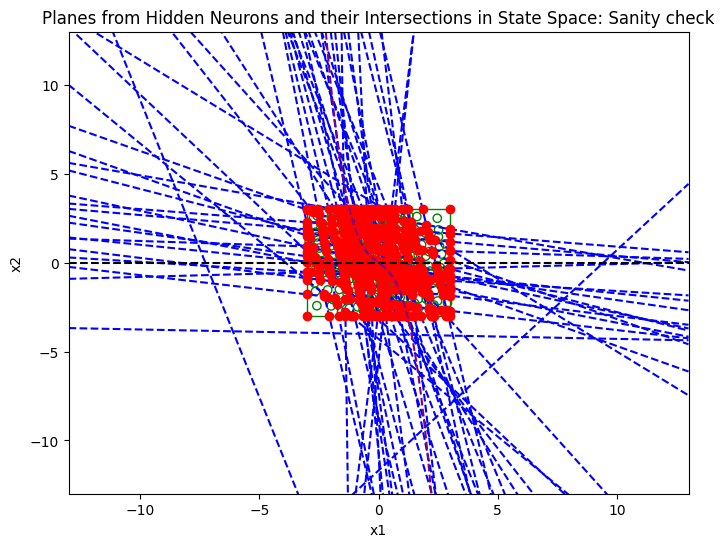

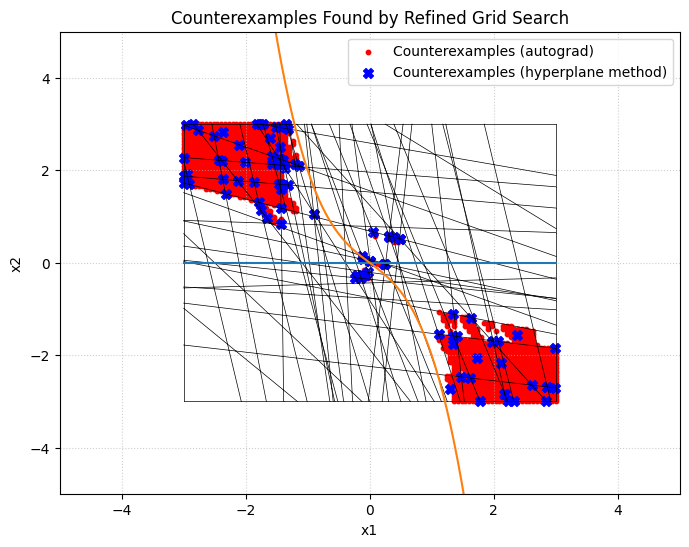

In [17]:

#Plot the hyperplanes generated from the hidden neurons
hyperplane_plot(x1_min, x1_max, x2_min, x2_max, W_matrix, B_vector, intersection_points, zero_level_functions)

autograd_counterexamples = autograd_and_counterexamples_plot(x1_min, x1_max, x2_min, x2_max, dynamics_list, duffing_nn, counter_examples, total_points_used, vertex_dict, edge_list, [duffing_f1_boundary,duffing_f2_boundary])


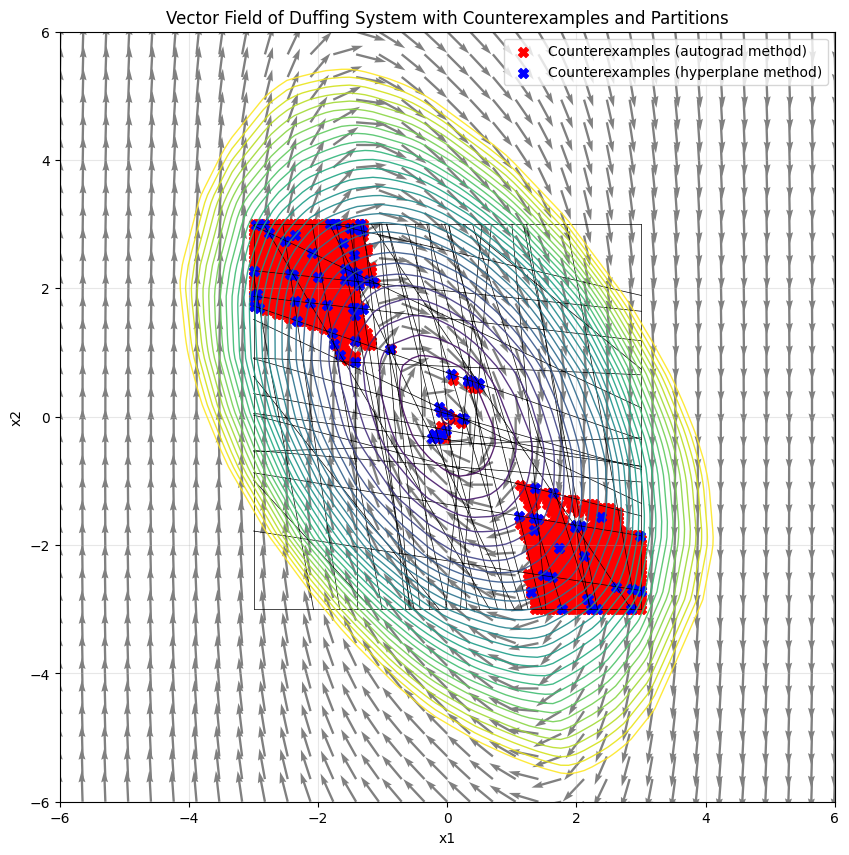

'counterexamples_field.html'

In [18]:
#plot the counterexamples found from refined grid search

# ========== MATPLOTLIB VERSION (Non-interactive) ==========
plt.figure(figsize=(10, 10))

# Compute vector field
x1_grid = np.linspace(-6, 6, 35)
x2_grid = np.linspace(-6, 6, 35)
X1, X2 = np.meshgrid(x1_grid, x2_grid)

f1_grid = np.zeros_like(X1)
f2_grid = np.zeros_like(X2)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x_pt = np.array([[X1[i, j]], [X2[i, j]]])
        f1_grid[i, j] = duffing_f1(x_pt)
        f2_grid[i, j] = duffing_f2(x_pt)

# Normalize vectors for quiver plot
magnitude = np.sqrt(f1_grid**2 + f2_grid**2)
magnitude[magnitude == 0] = 1
f1_normalized = f1_grid / magnitude
f2_normalized = f2_grid / magnitude

plt.quiver(X1, X2, f1_normalized, f2_normalized, scale=25, width=0.003, color='gray')

# Plot polygon regions (edges from hyperplane arrangement)
for edge in edge_list:
    v1 = vertex_dict[edge[0]]
    v2 = vertex_dict[edge[1]]
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color='black', linewidth=0.5)

# Plot counterexamples
if len(autograd_counterexamples) > 0:
    x1_ce_auto = [pt[0] for pt in autograd_counterexamples]
    x2_ce_auto = [pt[1] for pt in autograd_counterexamples]
    plt.scatter(x1_ce_auto, x2_ce_auto, color='red', s=50, label='Counterexamples (autograd method)', marker='X')

if len(counter_examples) > 0:
    x1_ce_poly = [pt[0] for pt in counter_examples]
    x2_ce_poly = [pt[1] for pt in counter_examples]
    plt.scatter(x1_ce_poly, x2_ce_poly, color='blue', s=50, label='Counterexamples (hyperplane method)', marker='X')

# Plot level contours of V
x1_contour = np.linspace(-6, 6, 100)
x2_contour = np.linspace(-6, 6, 100)
X1_contour, X2_contour = np.meshgrid(x1_contour, x2_contour)
V_contour = np.zeros_like(X1_contour)
for i in range(X1_contour.shape[0]):
    for j in range(X1_contour.shape[1]):
        x1_pt = X1_contour[i, j]
        x2_pt = X2_contour[i, j]
        x_state = torch.tensor([[x1_pt, x2_pt]], dtype=torch.float32)
        V_contour[i, j] = duffing_nn(x_state).item()
        
contour_levels = np.linspace(0, 20, 30)
plt.contour(X1_contour, X2_contour, V_contour, levels=contour_levels, cmap='viridis', alpha=0.9, linewidths=1)

plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Vector Field of Duffing System with Counterexamples and Partitions')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ========== PLOTLY VERSION (Interactive web browser) ==========
fig = go.Figure()

# Recompute vector field for plotly (reuse same grid)
# Add vector field as quiver plot
scale_factor = 0.2
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        fig.add_trace(go.Scatter(
            x=[X1[i, j], X1[i, j] + f1_normalized[i, j] * scale_factor],
            y=[X2[i, j], X2[i, j] + f2_normalized[i, j] * scale_factor],
            mode='lines',
            line=dict(color='gray', width=1),
            hoverinfo='none',
            showlegend=False
        ))

# Add polygon regions (edges from the hyperplane arrangement)
for edge in edge_list:
    v1 = vertex_dict[edge[0]]
    v2 = vertex_dict[edge[1]]
    fig.add_trace(go.Scatter(
        x=[v1[0], v2[0]],
        y=[v1[1], v2[1]],
        mode='lines',
        line=dict(color='black', width=1.5),
        hoverinfo='none',
        showlegend=False
    ))

# Add counterexamples from autograd
if len(autograd_counterexamples) > 0:
    x1_ce_auto = [pt[0] for pt in autograd_counterexamples]
    x2_ce_auto = [pt[1] for pt in autograd_counterexamples]
    fig.add_trace(go.Scatter(
        x=x1_ce_auto, y=x2_ce_auto,
        mode='markers',
        name='Counterexamples (autograd method)',
        marker=dict(color='red', size=8, symbol='x')
    ))

# Add counterexamples from hyperplane method
if len(counter_examples) > 0:
    x1_ce_poly = [pt[0] for pt in counter_examples]
    x2_ce_poly = [pt[1] for pt in counter_examples]
    fig.add_trace(go.Scatter(
        x=x1_ce_poly, y=x2_ce_poly,
        mode='markers',
        name='Counterexamples (hyperplane method)',
        marker=dict(color='blue', size=8, symbol='x')
    ))

# Add level contours of V (reuse V_contour computed above)
fig.add_trace(go.Contour(
    z=V_contour,
    x=x1_contour,
    y=x2_contour,
    colorscale='Viridis',
    name='V contours',
    showscale=True,
    hoverinfo='z'
))

fig.update_layout(
    title='Vector Field of Duffing System with Counterexamples and Partitions (Interactive)',
    xaxis_title='x1',
    yaxis_title='x2',
    width=900,
    height=800,
    hovermode='closest'
)
fig.update_xaxes(range=[-6, 6])
fig.update_yaxes(range=[-6, 6], scaleanchor='x', scaleratio=1)

plot(fig, filename='counterexamples_field.html', auto_open=True)

/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_60804/3706716067.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



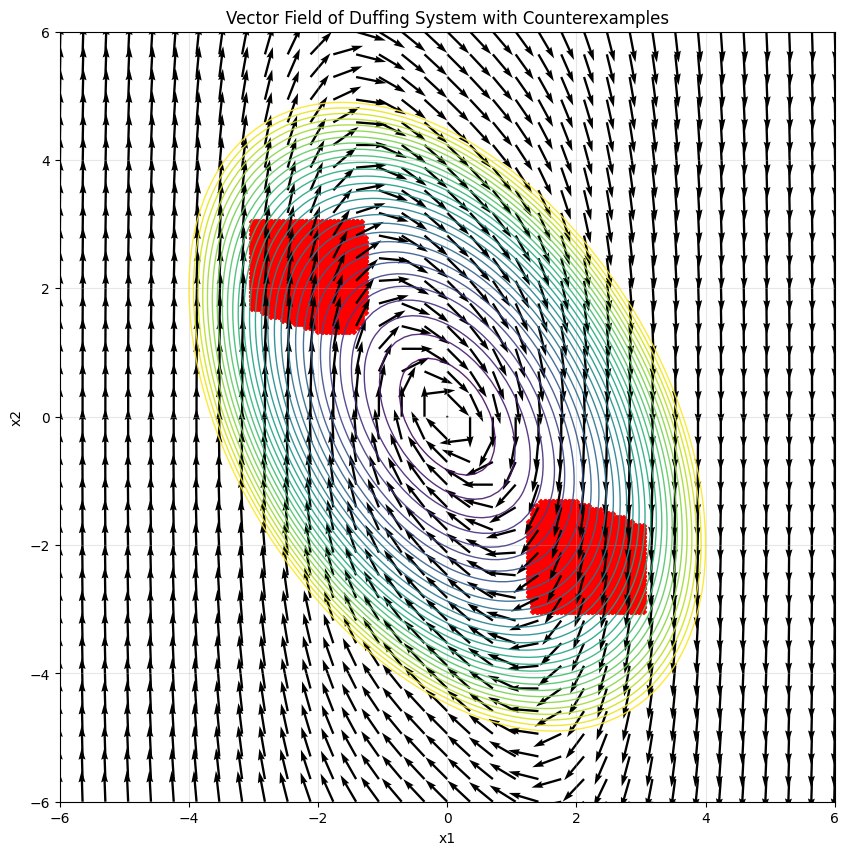

In [19]:
#first use a refined grid to find out where the counterexamples are with the true lyapunov function
#make a find grid in the box that we called the region of interest, and evaluate the lie derivative at each point to see if we can find any other counterexamples that we missed from the polygons
x1_grid = np.linspace(x1_min, x1_max, 100)
x2_grid = np.linspace(x2_min, x2_max, 100)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
lie_derivative_grid = np.zeros_like(X1)
true_counterexamples = []
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x1_pt = X1[i, j]
        x2_pt = X2[i, j]
        grad_pt= duffing_analytic_V_gradient(x1_pt, x2_pt)
        f1_val = dynamics_list[0](np.array([[x1_pt], [x2_pt]]))
        f2_val = dynamics_list[1](np.array([[x1_pt], [x2_pt]]))
        lie_derivative_grid[i, j] =grad_pt[0, 0] * f1_val + grad_pt[1, 0] * f2_val
        #if a point is positive add it to another counterexample list 
        if lie_derivative_grid[i, j] >= 1e-6:
            true_counterexamples.append((x1_pt, x2_pt))

plt.figure(figsize=(10, 10))

if len(true_counterexamples) > 0:
    x1_ce_true = [pt[0] for pt in true_counterexamples]
    x2_ce_true = [pt[1] for pt in true_counterexamples]
    plt.scatter(x1_ce_true, x2_ce_true, color='red', s=50, label='Counterexamples (true method)', marker='X')
#plot the vector field of the duffing system with counterexamples overlaid on it
x1_grid = np.linspace(-6, 6, 35)
x2_grid = np.linspace(-6, 6, 35)
X1, X2 = np.meshgrid(x1_grid, x2_grid)

# Compute vector field by evaluating dynamics at each point
f1_grid = np.zeros_like(X1)
f2_grid = np.zeros_like(X2)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x_pt = np.array([[X1[i, j]], [X2[i, j]]])
        f1_grid[i, j] = duffing_f1(x_pt)
        f2_grid[i, j] = duffing_f2(x_pt)
        # f1_grid[i, j] = x_pt[1, 0]
        # f2_grid[i, j] = -alpha * x_pt[0, 0] - delta * x_pt[1, 0]


# Normalize vectors for consistent arrow length
magnitude = np.sqrt(f1_grid**2 + f2_grid**2)
magnitude[magnitude == 0] = 1  # avoid division by zero
f1_normalized = f1_grid / magnitude
f2_normalized = f2_grid / magnitude

plt.quiver(X1, X2, f1_normalized, f2_normalized, scale=25, width=0.003)


plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Vector Field of Duffing System with Counterexamples')
plt.grid(True, alpha=0.3)
#plot the level contours of the neural lyapunov function 
x1_contour = np.linspace(-6, 6, 100)
x2_contour = np.linspace(-6, 6, 100)
X1_contour, X2_contour = np.meshgrid(x1_contour, x2_contour)
V_contour = np.zeros_like(X1_contour)
for i in range(X1_contour.shape[0]):
    for j in range(X1_contour.shape[1]):
        x1_pt = X1_contour[i, j]
        x2_pt = X2_contour[i, j]
        V_contour[i, j] = duffing_analytic_V(x1_pt, x2_pt)
contour_levels = np.linspace(0, 20, 30)
plt.contour(X1_contour, X2_contour, V_contour, levels=contour_levels, cmap='viridis', alpha=0.9, linewidths=1)





In [20]:
plot_web_plots(x1_min, x1_max, x2_min, x2_max, W_matrix, B_vector, intersection_points, total_points_used, counter_examples, duffing_f2_boundary)


In [21]:
def duffing_f1_x1(x1, x2):
    return 0 
def duffing_f1_x2(x1, x2):
    return 1
def duffing_f2_x1(x1, x2):
    return -alpha - 3 * beta * x1**2
def duffing_f2_x2(x1, x2):
    return -delta

def duffing_jacobian(x1, x2):
    J = np.array([[0, 1], [-alpha - 3 * beta * x1**2, -delta]])
#G(x1, x2) = F dot U => u_1 f_1 + u_2 f_2 
def G(x1, x2, U):
    F = np.array([[duffing_f1(x1, x2)], [duffing_f2(x1, x2)]])
    return np.dot(F, U.T)

#grad G = (u_1 f_1x1 + u_2 f_2x1, u_1 f_1x2 + u_2 f_2x2)
def grad_G(x1, x2, U):
    J = duffing_jacobian(x1, x2)
    grad = J.T @ U
    return grad




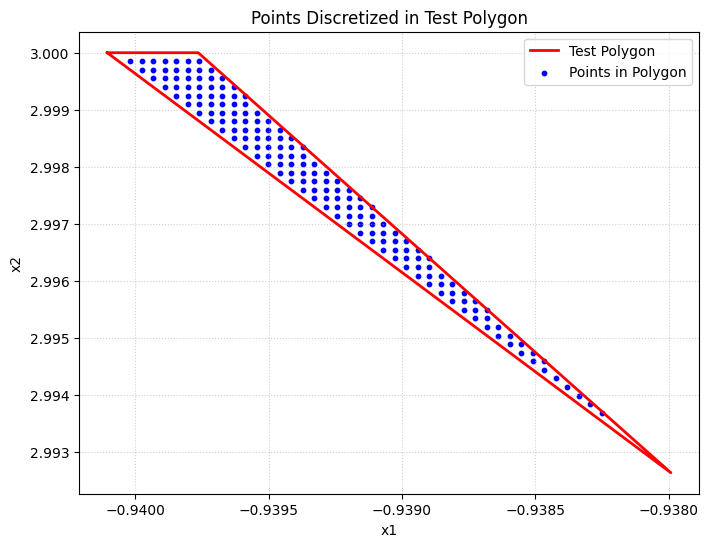

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#need TO FIND METTER WAY TO GET POITNS CLOSE TO VERTICES
test_polygon = polygons[100]
test_polygon_coords = [vertex_dict[v] for v in test_polygon]
test_polygon_coords.append(test_polygon_coords[0]) # close the polygon
x_coords = [coord[0] for coord in test_polygon_coords]
y_coords = [coord[1] for coord in test_polygon_coords]
#we will just do cartesian clipping since the polygons are convex
x_min = min(x_coords)
x_max = max(x_coords)
y_min = min(y_coords)
y_max = max(y_coords)
refinement = 50
x_grid = np.linspace(x_min, x_max, refinement)
y_grid = np.linspace(y_min, y_max, refinement)
X, Y = np.meshgrid(x_grid, y_grid)
points_in_polygon = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pt = (X[i, j], Y[i, j])
        if is_point_in_polygon(pt[0], pt[1], test_polygon_coords):
            points_in_polygon.append(pt)

plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Test Polygon')
x_pts = [pt[0] for pt in points_in_polygon]
y_pts = [pt[1] for pt in points_in_polygon]
plt.scatter(x_pts, y_pts, color='blue', s=10, label='Points in Polygon')
plt.title('Points Discretized in Test Polygon')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()